In [1]:
import cv2 as cv
import cv2
import numpy as np
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# plt.rcParams['figure.figsize'] = [20, 10]

def show_image(img):
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def show_comparison_image(img1, img2):
    plt.figure()
    plt.subplot(121)
    plt.imshow(img1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(img2)
    plt.xticks([]), plt.yticks([])
    plt.show()

    
def filter_ratio_matches(matches, kp1, kp2, ratio=0.7):
    new_kp1, new_kp2, new_matches = [], [], []
    ctr = 0
    for i, (m, n) in enumerate(matches):  #
        if m.distance < ratio * n.distance:
            new_kp1.append(kp1[m.queryIdx])
            new_kp2.append(kp2[m.trainIdx])
            new_matches.append([cv.DMatch(ctr, ctr, m.distance)])
            ctr += 1
    return new_matches, new_kp1, new_kp2

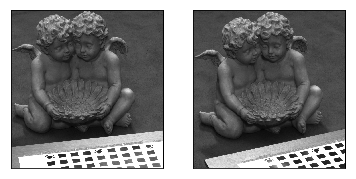

In [2]:
# img1 = cv.imread("data/Mesona1.JPG",0)
# img2 = cv.imread("data/Mesona2.JPG",0)
img1 = cv.imread("data/Statue1.bmp",0)
img2 = cv.imread("data/Statue2.bmp",0)

show_img1 = cv.cvtColor(img1, cv.COLOR_GRAY2RGB)
show_img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
show_comparison_image(show_img1, show_img2)

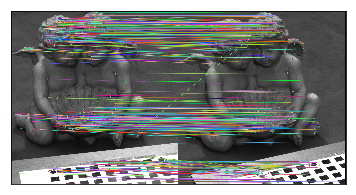

In [3]:

# Make SIFT Object
sift = cv.xfeatures2d.SIFT_create()

# Detect Local Descriptors and Keypoints
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Brute Force Local Descripter Matcher
bf = cv.BFMatcher(cv.NORM_L2)

# For each local descriptor des1, find 2 best correspondence from des 2
matches = bf.knnMatch(des1, des2, k=2)  # Think of it just finding a cluster of ssd.

matches, kp1, kp2 = filter_ratio_matches(matches, kp1, kp2, 0.75)

output_2 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, flags=2)

show_image(output_2)

In [4]:
def normalize2dpts(in_pts):
    centroid = np.array([in_pts[:,0].mean(), in_pts[:,1].mean(),0])
    pts = in_pts - centroid
    
    meandist = np.sqrt(pts[:,0]**2 + pts[:,1]**2).mean()
    scale = np.sqrt(2)/(meandist)
    
    T = np.array([[scale, 0, -scale*centroid[0]],
                  [0, scale, -scale*centroid[1]],
                  [0,0,1]])
    
    newpts = np.dot(T, in_pts.transpose()).transpose()
#     result = np.dot(np.linalg.inv(T), newpts.transpose()).transpose()
    return newpts, T

In [5]:
def fundmat(in_points_in_img1, in_points_in_img2):
    # normalize
    points_in_img1, T1 = normalize2dpts(in_points_in_img1)
    points_in_img2, T2 = normalize2dpts(in_points_in_img2)
    
    # Solve for A
    s = points_in_img1.shape[0]
    
    A = np.zeros((s, 9))
    for index in range(0, s):
        x, y = points_in_img1[index][0], points_in_img1[index][1]
        tx, ty = points_in_img2[index][0], points_in_img2[index][1]
        A[index] = [tx*x, tx*y, tx, ty*x, ty*y, ty, x,y,1]

    u, s, v = np.linalg.svd(A)
    F = v[-1].reshape(3, 3)  # eigenvector with the least eigenvalue
    
    u, s, v = np.linalg.svd(F)
    s[2] = 0
    F = np.dot(np.dot(u,np.diag(s)),v)

    # denormalize
    F = np.dot(np.dot(T2.transpose(),F),T1)

    return F/F[2,2]

def computeEpipoleLines(F, pts):
    lines = np.dot(F, pts.transpose()).transpose()
    n = np.sqrt(lines[:,0]**2 + lines[:,1]**2).reshape(-1,1)
    return lines / n * -1

def transformPtsToArrayPts(kp1, kp2, matches):
    tup_matches_kp1 = [kp1[dt[0].queryIdx].pt for dt in matches]
    tup_matches_kp2 = [kp2[dt[0].trainIdx].pt for dt in matches]
    matches_kp1 = np.array([[h for h in kp] + [1] for kp in tup_matches_kp1])
    matches_kp2 = np.array([[h for h in kp] + [1] for kp in tup_matches_kp2])
    return matches_kp1, matches_kp2

#http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT11/node12.html
#https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py
def computeEpipole(F):
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

def calculateSampsonDistance(matches_kp1, matches_kp2, F):
    Fx1 = np.dot(F,matches_kp1.transpose())
    Fx2 = np.dot(F.transpose(),matches_kp2.transpose())
    denom = (Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2).reshape(-1,1)
    err = (np.diag(np.dot(matches_kp2,np.dot(F,matches_kp1.transpose())))**2)
    err = err.reshape(-1,1) / denom
    return err

def randomPartition(n,n_data):
    """return n random rows of data (and also the other len(data)-n rows)"""
    all_idxs = np.arange( n_data )
    np.random.shuffle(all_idxs)
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2


In [6]:
def ransac(matches_kp1, matches_kp2, s=8, threshold=3,
           maxIterations=5000, returnMatches=False,
           inlierThreshold=50,confidence=0.99):
    
    cnt_matches = matches_kp1.shape[0]
    best_fit = []
    best_error = np.Infinity
    best_kp1, best_kp2 = [], []
    best_total = 0
    
    k= maxIterations
    for iter in range(k):
        maybe_idxs, test_idxs = randomPartition(s, cnt_matches)
        # Take s data points
        data_p1 = np.take(matches_kp1, maybe_idxs, axis=0)
        data_p2 = np.take(matches_kp2, maybe_idxs, axis=0)
        # Fit a fundamental matrix
        F = fundmat(data_p1, data_p2)
        
        # Test the current fundamental matrix
        test_p1 = np.take(matches_kp1, test_idxs, axis=0)
        test_p2 = np.take(matches_kp2, test_idxs, axis=0)
        errs = calculateSampsonDistance(test_p1, test_p2, F)
        
        # Initialize Current Matches
        current_p1, current_p2 = [], []
        current_total = 0
    

        
        inlier_indices = [errs[:,0] < threshold];
        current_p1 = np.append(data_p1, test_p1[inlier_indices], axis=0)
        current_p2 = np.append(data_p2, test_p2[inlier_indices], axis=0)
        current_total = current_p1.shape[0]
        
        if current_total > best_total and current_total >= inlierThreshold:
            better_fit = fundmat(current_p1, current_p2)
            better_err = calculateSampsonDistance(current_p1, current_p2, F)
            
            if (best_error > better_err.mean()):
                best_fit = better_fit
                best_kp1 = current_p1
                best_kp2 = current_p2
                best_total = current_p1.shape[0]
                
                # # we are done in case we have enough inliers
                r = current_total / cnt_matches
                nk = np.log(1-confidence)/np.log(1-pow(r,s))
                if iter > nk:
                    break
                
    
        
    print(str(best_total) + "/" + str(cnt_matches))
    if returnMatches:
        return best_fit, best_kp1, best_kp2
    
    return best_fit


matches_kp1, matches_kp2 = transformPtsToArrayPts(kp1, kp2, matches)
    
F, best_kp1, best_kp2 = ransac(matches_kp1,matches_kp2, returnMatches=True)
print(F)

439/491
[[ 1.07229302e-08 -5.80547679e-07 -1.00358536e-03]
 [-3.64115852e-07  7.61092277e-08 -2.78203037e-02]
 [-1.14820673e-03  2.83892391e-02  1.00000000e+00]]


<IPython.core.display.Javascript object>


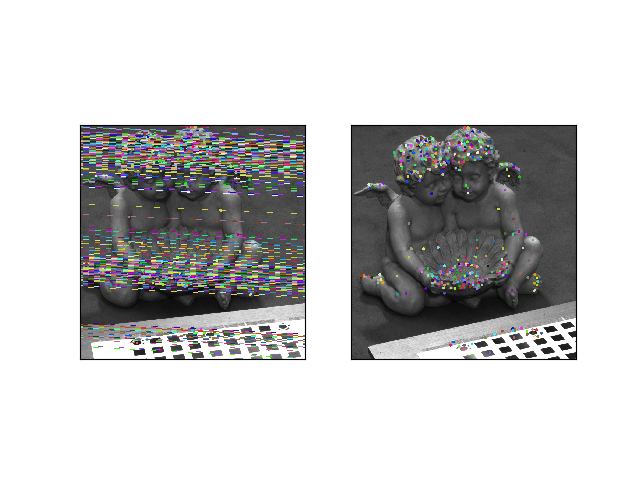

<IPython.core.display.Javascript object>


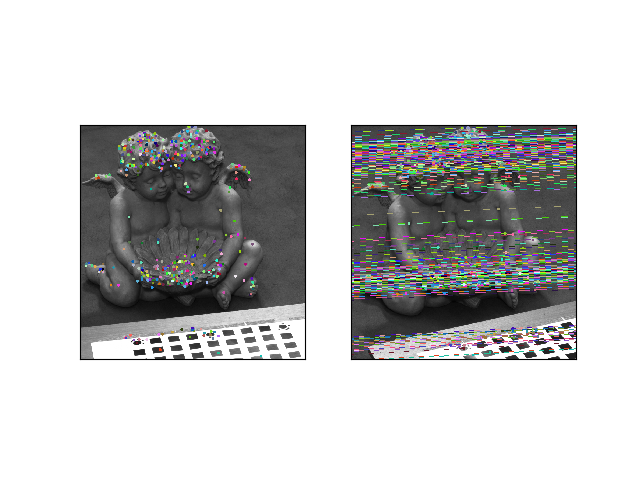

In [23]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    t_pts1= np.int32(pts1)
    t_pts2= np.int32(pts2)
    for r,pt1,pt2 in zip(lines,t_pts1,t_pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1[0:2]),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2[0:2]),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
# The first result
lines1 = computeEpipoleLines(F.transpose(), best_kp2)
img3,img4 = drawlines(img1,img2,lines1,best_kp1,best_kp2)
show_comparison_image(img3, img4)

# The first result
lines2 = computeEpipoleLines(F, best_kp1)
img5,img6 = drawlines(img2,img1,lines2,best_kp2,best_kp1)
show_comparison_image(img6, img5)



In [41]:
# Input Intrinsic Matrix
# K = np.array([[1.4219, 0.0005, 0.5092],[0, 1.4219, 0.3802],[0,0,0.0010]])
K1 = np.array([[5426.566895, 0.678017, 330.096680],[0.000000, 5423.133301, 648.950012],[0,0,1]])
K2 = np.array([[5426.566895, 0.678017, 387.430023], [0.000000, 5423.133301,620.616699] , [0,0,1]])

# Compute Essential Matrix from Fundamental Matrix and Intrinsic Matrix
E = np.dot(K1.transpose(), np.dot(F, K2))
# print(E)


def decomposeEssentialMatrix(E):
    # Decompose E
    u, s, v = np.linalg.svd(E)
    m = (s[1] + s[2])/2
    E = np.dot(np.dot(u,np.diag([m,m,0])),v)
    
    u, s, v = np.linalg.svd(E)
    w = np.array([[0,-1,-0],[1,0,0],[0,0,1]])
#     u3 = np.dot(u,np.array([0,0,1]).transpose()) # why?
    u3 = u[:,-1] # i am not sure why the last row of u3
    
    R1 = np.dot(u, np.dot(w, v))
    R2 = np.dot(u, np.dot(w.transpose(),v))
    
    return [np.vstack((R1.transpose(), u3)).transpose(), 
            np.vstack((R1.transpose(), -u3)).transpose(),
            np.vstack((R2.transpose(), u3)).transpose(),
            np.vstack((R2.transpose(), -u3)).transpose()]
    
R1,R2,u3 = cv.decomposeEssentialMat(E)
print(R1); print(R2); print(u3)
all_p2_solutions = decomposeEssentialMatrix(E)

[[ 9.99139326e-01 -8.82862631e-04  4.14708047e-02]
 [-5.93319086e-04 -9.99975368e-01 -6.99365384e-03]
 [ 4.14759576e-02  6.96302917e-03 -9.99115239e-01]]
[[ 0.97883285  0.09729267 -0.18005663]
 [-0.0963879   0.99524833  0.0137886 ]
 [ 0.18054259  0.00385854  0.9835596 ]]
[[ 0.99258184]
 [-0.04866691]
 [ 0.11141288]]
[[ 0.97883285  0.09729267 -0.18005663  0.99258184]
 [-0.0963879   0.99524833  0.0137886  -0.04866691]
 [ 0.18054259  0.00385854  0.9835596   0.11141288]]


In [42]:
p1 = np.vstack((np.eye(3), np.zeros(3))).transpose()
p2 = all_p2_solutions[0] # just take one as an example
print(p1)
print(p2)

def getRmatAndTmat(p):
    R= p1[:, :3];t = p1[:, 3];
    return R, t

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[ 0.97883285  0.09729267 -0.18005663  0.99258184]
 [-0.0963879   0.99524833  0.0137886  -0.04866691]
 [ 0.18054259  0.00385854  0.9835596   0.11141288]]


In [48]:
def triangulatePoint(point_1, point_2, p1, p2):
    # define A
    u1, v1 = point_1[0], point_1[1]
    u2, v2 = point_2[0], point_2[1]
    
    A= np.zeros((4,4))
    
    A[0] = u1*p1[2] - p1[0]
    A[1] = v1*p1[2] - p1[1]
    A[2] = u2*p2[2] - p2[0]
    A[3] = v2*p2[2] - p2[1]
    
    u,s,v = np.linalg.svd(A)
    x = v[-1]
#     x = x / x[-1] # with the last point
    return x

def triangulate(pts1, pts2, p1, p2):
    R1,t1 = getRmatAndTmat(p1)
    R2,t2 = getRmatAndTmat(p2)
    
    # compute camera centers
    C1 = -np.dot(R1.transpose(), t1)
    C2 = -np.dot(R2.transpose(), t2)
    
    V1 = np.dot(R1.transpose(), np.array([0,0,1]))
    V2 = np.dot(R2.transpose(), np.array([0,0,1]))
    
    points = []
    for pt1, pt2 in zip(pts1, pts2):
        point_in_3d = triangulatePoint(pt1, pt2, p1, p2)[:3]
        test1 = np.dot((point_in_3d-C1),V1)
        test2 = np.dot((point_in_3d-C2),V2)
#         if (test1 > 0 and test2 > 0):
        points.append(point_in_3d)
            
    return np.array(points)


print(triangulatePoint(best_kp1[0,:2], best_kp2[0,:2], p1, p2))

points = cv2.triangulatePoints(p1, p2, best_kp1[:,:2].transpose(),best_kp2[:,:2].transpose()).transpose()
print(points)
# %matplotlib notebook
# points = triangulate(best_kp1, best_kp2, p1, all_p2_solutions[2])
# # print(points)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2], c='r', marker='o')



[-0.49756323 -0.27204535 -0.0009687   0.82366329]
[[-4.97563230e-01 -2.72045353e-01 -9.68695649e-04  8.23663293e-01]
 [-5.05791434e-01 -2.27127662e-01 -5.02133676e-04  8.32218600e-01]
 [-4.12877726e-01 -5.89739890e-01 -1.11188074e-03  6.94073202e-01]
 ...
 [-3.79375014e-01 -6.65966429e-01 -1.28279473e-03  6.42309636e-01]
 [-5.16648202e-01 -7.13197243e-02 -1.01018975e-03  8.53221607e-01]
 [-4.97379168e-01 -2.77214888e-01 -7.93232253e-04  8.22049415e-01]]
